# I. Prepare data

In [1]:
from tqdm import tqdm
from lxml import etree
import os, nltk
from keras.callbacks import EarlyStopping, TensorBoard

Using TensorFlow backend.


In [2]:
topic_tree = etree.parse('data/topics2016.xml')

def get_topic(i):# returns the summary string of the ith topic
    summary = topic_tree.xpath('//topic[@number="%d"]/summary/text()'%i)
    return str(summary).lower()

# build a mapping of article name (PMCID) to its file path

PMC_PATH = '/local/XW/DATA/TREC/PMCs/'
pmcid2fpath = {}

for subdir1 in os.listdir(PMC_PATH):
    for subdir2 in os.listdir(os.path.join(PMC_PATH, subdir1)):
        diry = os.path.join(PMC_PATH, subdir1, subdir2)
#         print diry, len(os.listdir(diry))
        for fn in os.listdir(diry):
            pmcid = fn[:-5]
            fpath = os.path.join(diry, fn)
            pmcid2fpath[pmcid] = fpath

def get_article_abstract(pmcid):
    fpath = pmcid2fpath[pmcid]
    tree = etree.parse(fpath)
    abstract = tree.xpath('//abstract')[0]
    ret = u''+abstract.xpath('string(.)')
    return ret.lower()

In [3]:
query = get_topic(1)

In [4]:
corpus = []
pmcid_2relevance = [{} for i in xrange(31)] # list of dict mapping pmcid to relevance
with open('data/qrels.txt') as f:
    for line in tqdm(f, total=37707): 
        topicid, _, pmcid, relevance = line.split()
        topicid = int(topicid)
        if topicid>3: break
        try:
            corpus.append(get_article_abstract(pmcid))
            pmcid_2relevance[topicid][pmcid] = int(relevance)
        except: pass

 11%|█         | 4174/37707 [00:04<00:40, 836.64it/s]


In [5]:
len(corpus)

3871

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(corpus)

def get_idf(wd):
    if wd not in vectorizer.vocabulary_: return 1.0
    return vectorizer.idf_[ vectorizer.vocabulary_[wd] ]

In [7]:
vocab = set(vectorizer.vocabulary_.keys())

In [8]:
import os, sys, time
import numpy as np
from numpy.linalg import norm
import pandas as pd
from tqdm import tqdm
import cPickle as pk
np.random.seed(1) # to be reproducible

In [9]:
W2V_FPATH = '/local/XW/DATA/WORD_EMBEDDINGS/biomed-w2v-200.txt'
GLOVE_FPATH = '/local/XW/DATA/WORD_EMBEDDINGS/glove.6B.200d.txt'

In [10]:
word2vec = {} # maps word ---> embedding vector
with open(GLOVE_FPATH) as f:
    for line in tqdm(f, total=400000): #5443657 400000
        vals = line.split()
        word = vals[0]
        if word in vocab:
            vec = np.asarray(vals[1:], dtype='float')
            word2vec[word] = vec
print 'found %d word vectors.' % len(word2vec)

100%|██████████| 400000/400000 [00:04<00:00, 98328.13it/s] 

found 19408 word vectors.


# II. Define the deep relevance model

In [11]:
# define a function for visualization of model
import pydot
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
def viz_model(model):
    return SVG(model_to_dot(model).create(prog='dot', format='svg'))

### construct the relevance IR model

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, InputLayer, Flatten, Input, Merge, merge, Reshape
import keras.backend as K
import tensorflow as tf

In [13]:
N = len(query.split())

In [14]:
# 2 main components of the structure: feed forward network and gating
feed_forward = Sequential(
    [Dense(input_dim=30, output_dim=5, activation='tanh'),
     Dense(output_dim=1, activation='tanh')], 
    name='feed_forward_nw')

# ***note: have to wrap ops into Lambda layers !!***
# cf: https://groups.google.com/forum/#!topic/keras-users/fbRS-FkZw_Q
from keras.layers.core import Lambda

input_idf = Input(shape=(N,), name='input_idf')
def scale(x): 
    w = K.variable(1, name='w_g')
    return K.mul(x,w)
def scale_output_shape(input_shape): return input_shape

scaled = Lambda(scale, scale_output_shape, name='softmax_scale')(input_idf)
gs_out = Activation('softmax', name='softmax')(scaled)
gating = Model(input=input_idf, output=gs_out, name='gating')

In [84]:
# first input
input_hists = Input(shape=(N,30), name='input_hists')

def slicei(x, i): return x[:,i,:]
def slicei_output_shape(input_shape): return (input_shape[0], input_shape[2])
zs = [ feed_forward( Lambda(lambda x:slicei(x,i), slicei_output_shape, name='slice%d'%i)(input_hists) )\
          for i in xrange(N) ]

def concat(x): return K.concatenate(x) 
def concat_output_shape(input_shape): return (input_shape[0][0], N)
zs = Lambda(concat, concat_output_shape, name='concat_zs')(zs)

# second input
input_idf = Input(shape=(N,), name='input_idf')
gs = gating(input_idf)

def innerprod(x): return K.sum( K.mul(x[0],x[1]), axis=1)
def innerprod_output_shape(input_shape): return (input_shape[0][0],1)
scores = Lambda(innerprod, innerprod_output_shape, name='innerprod_zs_gs')([zs, gs])

scoring_model = Model(input=[input_idf, input_hists], output=[scores], name='scoring_model')

In [153]:
# third input -- the negative hists vector 
input_hists_neg = Input(shape=(N,30), name='input_hists_neg')

zs_neg = [ feed_forward( Lambda(lambda x:slicei(x,i), slicei_output_shape, name='slice%d_neg'%i)(input_hists_neg) )\
          for i in xrange(N) ]

zs_neg = Lambda(concat, concat_output_shape, name='concat_zs_neg')(zs_neg)

scores_neg = Lambda(innerprod, innerprod_output_shape, name='innerprod_zs_gs_neg')([zs_neg, gs])

two_score_model = Model(input=[input_idf, input_hists, input_hists_neg], 
                        output=[scores, scores_neg], 
                        name='2scoring_model')

In [154]:
two_score_model.predict([idf_sample, pair_sample, pair_sample])

[array([-0.57720977, -0.09897145], dtype=float32),
 array([-0.57720977, -0.09897145], dtype=float32)]

In [85]:
print scoring_model.layers[-1].name
print scoring_model.layers[-1].output_shape
print scoring_model.layers[-1].input_shape

innerprod_zs_gs
(None, 1)
[(None, 11), (None, 11)]


In [86]:
scoring_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_hists (InputLayer)         (None, 11, 30)        0                                            
____________________________________________________________________________________________________
slice0 (Lambda)                  (None, 30)            0           input_hists[0][0]                
____________________________________________________________________________________________________
slice1 (Lambda)                  (None, 30)            0           input_hists[0][0]                
____________________________________________________________________________________________________
slice2 (Lambda)                  (None, 30)            0           input_hists[0][0]                
___________________________________________________________________________________________

In [90]:
input_hists_pos = Input(shape=(N,30,), name='input_hists_pos')
input_hists_neg = Input(shape=(N,30,), name='input_hists_neg')

scores_pos = scoring_model([input_idf, input_hists_pos])
scores_neg = scoring_model([input_idf, input_hists_neg])

def diff(x): return tf.sub(x[0], x[1]) #x[0]-x[1]
def diff_output_shape(input_shape): return input_shape[0]
diff = Lambda(diff, diff_output_shape, name='posneg_score_diff')([scores_pos, scores_neg])

ranking_model = Model(input=[input_idf, input_hists_pos,  input_hists_neg]
                      , output=[diff]
                      , name='ranking_model')

In [91]:
# define my loss function: hinge of score_pos - score_neg
def pairwise_hinge(y_true, y_pred): # y_pred = score_pos - score_neg, **y_true doesn't matter here**
    return K.mean( K.maximum(1. - y_pred, y_true*0.0) )  

ranking_model.compile(optimizer='adagrad', loss=pairwise_hinge)

In [92]:
ranking_model.output_shape

(None, 1)

In [93]:
ranking_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_idf (InputLayer)           (None, 11)            0                                            
____________________________________________________________________________________________________
input_hists_pos (InputLayer)     (None, 11, 30)        0                                            
____________________________________________________________________________________________________
input_hists_neg (InputLayer)     (None, 11, 30)        0                                            
____________________________________________________________________________________________________
scoring_model (Model)            (None, 1)             161         input_idf[0][0]                  
                                                                   input_hists_pos[0][0]   

## below are some testing stuff

In [95]:
zip(pos_ids[:10], neg_ids[:10])

[('3429740', '3921765'),
 ('2999735', '4085271'),
 ('3526517', '4532844'),
 ('1750992', '2769307'),
 ('3503351', '3809984'),
 ('4130891', '4685986'),
 ('4471306', '2996340'),
 ('3286730', '4395018'),
 ('4659952', '28994'),
 ('4724023', '4716452')]

In [96]:
pos_sample = get_query_doc_feature(query, '3429740')
neg_sample = get_query_doc_feature(query, '3921765')
pair_sample = np.array([pos_sample, neg_sample])

_idf = np.array([get_idf(wd) for wd in query.split()])
idf_sample = np.vstack([_idf]*2)

print idf_sample.shape, pair_sample.shape

(2, 11) (2, 11, 30)


### test `scoring_model`

In [97]:
scoring_model.predict([idf_sample,pair_sample])

array([-0.57720977, -0.09897145], dtype=float32)

In [111]:
a = feed_forward.predict(pos_sample)
print a

[[-0.04990714]
 [ 0.20103526]
 [-0.9998787 ]
 [-0.99933815]
 [ 0.81653112]
 [-0.7265538 ]
 [-0.99144602]
 [-0.99986547]
 [-0.98050851]
 [-0.99987775]
 [-0.04990714]]


In [99]:
b = gating.predict(idf_sample)[0]
print b

[ 0.00482637  0.20997439  0.0174815   0.02042374  0.0538551   0.20764136
  0.00537621  0.12458481  0.34606892  0.00494123  0.00482637]


In [112]:
b.dot(a)

array([-0.57720971], dtype=float32)

In [113]:
c = feed_forward.predict(neg_sample)
print c
print b.dot(c)

[[ 0.83937836]
 [ 0.00692836]
 [-0.99940413]
 [-0.99986506]
 [ 0.8202067 ]
 [ 0.18778783]
 [-0.99873543]
 [-0.98785001]
 [-0.05901096]
 [-0.99953288]
 [ 0.83937836]]
[-0.09897143]


==> the scoring model works all right

**but when adding another input layer, the output is incorrect!**

In [148]:
idf_in = Input((N,))
hists_in = Input((N,30))
score_out = scoring_model([idf_in, hists_in])
_model = Model(input=[idf_in, hists_in], output=score_out)

In [150]:
_model.predict([idf_sample, pair_sample])

array([-0.04990714,  0.83937836], dtype=float32)

### test ranking_model

In [102]:
ranking_model.predict( [idf_sample, pair_sample, np.array([neg_sample, pos_sample]) ])

array([-0.8892855,  0.8892855], dtype=float32)

==> **strange**, the ranking models gives `score_pos - score_neg = -0.8892855`,   
but from what we have in `scoring_model`, it should be `-0.5772+0.1954 = -0.3818`

In [54]:
ranking_model.layers[-2].name

'scoring_model'

In [137]:
my_fw_input = Input((30,))
my_fw_output = feed_forward(my_fw_input)
my_fw_model = Model(input=my_fw_input, output=my_fw_output)
my_fw_model.predict(pos_sample)

array([[-0.04990714],
       [ 0.20103526],
       [-0.9998787 ],
       [-0.99933815],
       [ 0.81653112],
       [-0.7265538 ],
       [-0.99144602],
       [-0.99986547],
       [-0.98050851],
       [-0.99987775],
       [-0.04990714]], dtype=float32)

In [138]:
my2nd_input = Input((30,))
my_2nd_output = my_fw_model(my2nd_input)
my_2nd_fwmodel = Model(input=my2nd_input, output=my_2nd_output)
my_2nd_fwmodel.predict(pos_sample)

array([[-0.04990714],
       [ 0.20103526],
       [-0.9998787 ],
       [-0.99933815],
       [ 0.81653112],
       [-0.7265538 ],
       [-0.99144602],
       [-0.99986547],
       [-0.98050851],
       [-0.99987775],
       [-0.04990714]], dtype=float32)

In [140]:
my_gatingin = Input((N,))
my_gatingout = gating(my_gatingin)
my_gatingmodel = Model(input=my_gatingin, output=my_gatingout)
my_gatingmodel.predict(idf_sample)

array([[ 0.00482637,  0.20997439,  0.0174815 ,  0.02042374,  0.0538551 ,
         0.20764136,  0.00537621,  0.12458481,  0.34606892,  0.00494123,
         0.00482637],
       [ 0.00482637,  0.20997439,  0.0174815 ,  0.02042374,  0.0538551 ,
         0.20764136,  0.00537621,  0.12458481,  0.34606892,  0.00494123,
         0.00482637]], dtype=float32)

In [145]:
ascore = scoring_model([my_gatingin, ahistinput])
amodel = Model(input=[my_gatingin, ahistinput], output=ascore)
amodel.predict( [idf_sample, pair_sample])

array([-0.04990714,  0.83937836], dtype=float32)

In [146]:
amodel.input_shape

[(None, 11), (None, 11, 30)]

In [147]:
scoring_model.input_shape

[(None, 11), (None, 11, 30)]

In [133]:
scoring_model.inputs

[<tf.Tensor 'input_idf_8:0' shape=(?, 11) dtype=float32>,
 <tf.Tensor 'input_hists_7:0' shape=(?, 11, 30) dtype=float32>]

In [131]:
ahistinput = Input(shape=(N,30))
aidfinput = Input(shape=(N,), name='aidfinput')
ascore = scoring_model.([aidfinput, ahistinput])
amodel = Model(input=[aidfinput, ahistinput], output=ascore)

In [132]:
amodel.predict( [idf_sample, pair_sample] )

array([-0.04990714,  0.83937836], dtype=float32)

In [117]:
input_hists_pos = Input(shape=(N,30), name='input_hists_pos')
input_hists_neg = Input(shape=(N,30), name='input_hists_neg')

scores_pos = scoring_model([input_idf, input_hists_pos])
scores_neg = scoring_model([input_idf, input_hists_neg])

twoscore_model = Model(input=[input_idf, input_hists_pos,  input_hists_neg]
                      , output=[scores_pos, scores_neg]
                      , name='twoscore_model')

In [118]:
onescore_model = Model(input=[input_idf, input_hists_pos], output = [scores_pos])

In [119]:
onescore_model.predict([idf_sample, pair_sample])

array([-0.04990714,  0.83937836], dtype=float32)

In [123]:
scoring_model.input_shape

[(None, 11), (None, 11, 30)]

In [120]:
twoscore_model.predict( [idf_sample, pair_sample, np.array([neg_sample, pos_sample]) ] )

[array([-0.04990714,  0.83937836], dtype=float32),
 array([ 0.83937836, -0.04990714], dtype=float32)]

In [107]:
twoscore_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_idf (InputLayer)           (None, 11)            0                                            
____________________________________________________________________________________________________
input_hists_pos (InputLayer)     (None, 11, 30)        0                                            
____________________________________________________________________________________________________
input_hists_neg (InputLayer)     (None, 11, 30)        0                                            
____________________________________________________________________________________________________
scoring_model (Model)            (None, 1)             161         input_idf[0][0]                  
                                                                   input_hists_pos[0][0]   

# III. train model (for topic-1)

## helper functions

In [24]:
randvec = np.random.randn(200)
def get_histvec(q_wd, doc):
    qvec = word2vec.get(q_wd, randvec)
#     dvecs = np.vstack( [word2vec.get(wd, randvec) for wd in nltk.word_tokenize(doc)] )
    words_doc = filter(lambda wd:wd in word2vec, nltk.word_tokenize(doc))
    dvecs = np.vstack( [ word2vec[wd] for wd in words_doc ] )
    cossims = np.dot(dvecs, qvec) / norm(qvec) / norm(dvecs, axis=1)
    hist, _ = np.histogram( cossims[cossims<1.0], bins=29, range=(-1,1) )
    ones = len(cossims) - sum(hist)
    ret = np.array( list(hist) + [ones] )
    return ret # np.reshape(ret, (-1, 30))

In [25]:
def get_query_doc_feature(query, pmcid):
    doc = get_article_abstract(pmcid)
    return np.array([ get_histvec(wd, doc) for wd in query.split()])

## prepare positive/negative pairs

In [26]:
relevance = pmcid_2relevance[1]

In [27]:
pos_ids, neg_ids = [], []
for pmcid in relevance.keys():
    if relevance[pmcid]==0: neg_ids.append(pmcid)
    else: pos_ids.append(pmcid)
print len(pos_ids), len(neg_ids)

125 1209


In [28]:
hists_pos = np.array( [get_query_doc_feature(query, posid) for posid in tqdm(pos_ids)] )
hists_neg = np.array( [get_query_doc_feature(query, negid) for negid in tqdm(neg_ids)] )

100%|██████████| 1209/1209 [00:33<00:00, 35.71it/s]


## train model using `fit_generator`

In [29]:
VALDATION_SPLIT = 0.2
BATCH_SZ = 128
NB_EPOCH = 20

In [30]:
idx_pairs = []
for pidx in xrange(len(hists_pos)):
    for nidx in xrange(len(hists_neg)):
        idx_pairs.append( (pidx, nidx) )
idx_pairs = np.array(idx_pairs)
val_sz = int(len(idx_pairs)*VALDATION_SPLIT)
idx_pairs_train, idx_pairs_val = idx_pairs[val_sz:], idx_pairs[:val_sz]

In [31]:
def batch_generator(idx_pairs, batch_size=BATCH_SZ): 
    np.random.shuffle(idx_pairs)
    batches_pre_epoch = len(idx_pairs) //batch_size
    samples_per_epoch = batches_pre_epoch * batch_size # make samples_per_epoch a multiple of batch size
    counter = 0
    _idf = np.array([get_idf(wd) for wd in query.split()])
    idfs_batch = np.vstack([_idf]*batch_size)
    y_true_batch_dummy = np.ones((batch_size))
    while 1:
        idx_batch = idx_pairs[batch_size*counter: min(samples_per_epoch, batch_size*(counter+1))]
        pos_batch = hists_pos[idx_batch[:,0]]
        neg_batch = hists_neg[idx_batch[:,1]]
        counter += 1
        if (counter >= batches_pre_epoch):
            np.random.shuffle(idx_pairs)
            counter=0
        yield [idfs_batch, pos_batch, neg_batch], y_true_batch_dummy

In [94]:
logdir = './log/relevance_matching'
_callbacks = [EarlyStopping(monitor='val_loss', patience=2),
              TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=False) # 
             ]

ranking_model.fit_generator( batch_generator(idx_pairs_train), 
                    samples_per_epoch = len(idx_pairs_train)//BATCH_SZ*BATCH_SZ,
                    nb_epoch=NB_EPOCH,
                    validation_data=batch_generator(idx_pairs_val),
                    nb_val_samples=len(idx_pairs_val)//BATCH_SZ*BATCH_SZ, 
                    callbacks = _callbacks)

Epoch 1/20
120832/120832 [==============================] - 6s - loss: 0.6785 - val_loss: 0.6921
Epoch 2/20
120832/120832 [==============================] - 6s - loss: 0.6729 - val_loss: 0.6961
Epoch 3/20
120832/120832 [==============================] - 6s - loss: 0.6701 - val_loss: 0.6979
Epoch 4/20
120832/120832 [==============================] - 6s - loss: 0.6682 - val_loss: 0.6982


================================================

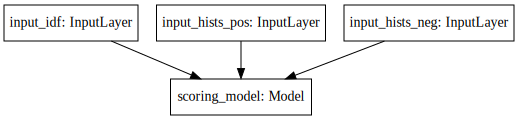

In [114]:
viz_model(twoscore_model)

In [144]:
my_input = Input(shape=(30,), name='input_hists_neg')
my_fw = feed_forward(my_input)
my_fw_model = Model(input=[my_input], output=my_fw)

a = my_fw_model.predict(hists)
a

array([[-0.892479  ],
       [-0.706613  ],
       [ 0.80454189],
       [-0.99935871],
       [ 0.58757395],
       [-0.09228716],
       [ 0.51544785],
       [-0.97222841],
       [-0.69008142],
       [-0.98593205],
       [-0.892479  ]], dtype=float32)

In [89]:
my_input = Input(shape=(N,30,), name='input_hists_neg')
my_output = scoring_model([input_idf,my_input])
my_scoring_model = Model(input=[input_idf, my_input], output=my_output)

In [103]:
my_scoring_model.predict([_idf, hists.reshape(1,11,30)])

array([-0.05468409], dtype=float32)

In [119]:
input_hists_neg[0][0]

<tf.Tensor 'strided_slice_168:0' shape=(30,) dtype=float32>

In [114]:
my_scoring_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_idf (InputLayer)           (None, 11)            0                                            
____________________________________________________________________________________________________
input_hists_neg (InputLayer)     (None, 11, 30)        0                                            
____________________________________________________________________________________________________
model_4 (Model)                  ((None, 1), 11)       161         input_idf[0][0]                  
                                                                   input_hists_neg[0][0]            
Total params: 161
____________________________________________________________________________________________________


In [102]:
scoring_model.predict([_idf, hists.reshape(1,11,30)])

array([-0.66346824], dtype=float32)

In [120]:
scoring_model.input_shape

[(None, 11), (None, 11, 30)]

In [63]:
zs = np.array([feed_forward.predict(hists[i].reshape((1,30)))[0][0] for i in xrange(11)])
print zs

gs = gating.predict(_idf)[0]
print gs

np.dot(gs, zs)

[-0.05468409 -0.192092   -0.99987549 -0.99966365  0.81075352 -0.72527534
 -0.99130666 -0.99986106 -0.9802199  -0.99987501 -0.05468409]
[ 0.00178642  0.21126346  0.01758882  0.02054912  0.05418573  0.20891611
  0.00540922  0.12534966  0.3481935   0.00497156  0.00178642]


-0.66346824

In [65]:
_idf = np.array([get_idf(wd) for wd in query.split()])
_idf = np.vstack([_idf])
def predict_score(pmcid):
    _hist = get_query_doc_feature(query, pmcid).reshape(1,11,30)
    return scoring_model.predict([_idf, _hist])[0]

In [87]:
_idf

array([[ 0.        ,  4.77289008,  2.28704754,  2.44260238,  3.41220167,
         4.76171678,  1.10788896,  4.25089115,  5.2725424 ,  1.0235182 ,
         0.        ]])

In [66]:
def predict_score_diff( (pmcid_pos, pmcid_neg) ):
    hist_pos = get_query_doc_feature(query, pmcid_pos).reshape((1,11,30))
    hist_neg = get_query_doc_feature(query, pmcid_neg).reshape((1,11,30))
    return ranking_model.predict([_idf, hist_pos, hist_neg])[0]

In [67]:
pos_score, neg_score = predict_score('3429740'), predict_score('3921765')
print pos_score, neg_score, pos_score-neg_score

-0.663468 -0.202128 -0.46134


In [68]:
predict_score_diff( ('3429740','3921765') )

-0.89171958

In [77]:
scores_model = Model(input=[input_idf, input_hists_pos,  input_hists_neg], output=[scores_pos, scores_neg])

In [82]:
def predict_two_scores( (pmcid_pos, pmcid_neg) ):
    hist_pos = get_query_doc_feature(query, pmcid_pos).reshape((1,11,30))
    hist_neg = get_query_doc_feature(query, pmcid_neg).reshape((1,11,30))
    return scores_model.predict([_idf, hist_pos, hist_neg])

In [86]:
predict_two_scores(('3429740','3921765'))

[array([-0.05468409], dtype=float32), array([ 0.83703548], dtype=float32)]

In [69]:
map( predict_score_diff, zip(pos_ids[:10], neg_ids[:10]) )

[-0.89171958,
 -1.779403,
 0.86472356,
 1.1238645,
 -0.096291691,
 0.82808971,
 1.9493514,
 0.010176122,
 0.90994984,
 1.8916705]

In [70]:
zip( map(predict_score, pos_ids[:10]), map(predict_score, neg_ids[:10]) )

[(-0.66346824, -0.20212805),
 (-0.49923095, -0.84202075),
 (0.15193824, -0.51340085),
 (-0.25755185, -0.33610663),
 (-0.73453307, -0.87871718),
 (-0.83638602, -0.42952284),
 (-0.89103198, -0.55013555),
 (-0.70775616, -0.73655176),
 (-0.73875976, -0.46259823),
 (-0.7495991, -0.76382387)]